# Kr NEW Compare KrMap - ICAROS Map

J. A Hernando, C. Herves

May 2022

In [1]:
%matplotlib inline 

#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import pandas            as pd
import tables            as tb
from   scipy             import stats
from   scipy             import optimize

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

plt.rcParams['image.cmap'] = 'rainbow'

In [3]:
import hipy.utils        as ut
import hipy.pltext       as pltext
import hipy.profile      as prof

import nana.kr.krana    as krana
import nana.kr.icaros   as icaros

#import nana.bclouds.bclouds      as bc
#import hipy.hfit         as hfit
from invisible_cities.io.dst_io import load_dst, load_dsts
#import invisible_cities.io.dst_io as dio

In [4]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Mon May 16 22:08:28 2022


In [5]:
#import os
import re
import glob

from collections import namedtuple

## Access Maps

In [8]:
path = '/Users/hernando/work/investigacion/NEXT/data/NEW/'
runs = 8182, 8183, 8184

run = 8182
mapfilename = path + 'Kr/maps/map_' + str(run) + '.h5'
icaromap  = icaros.get_map(mapfilename)
icarocorz = icaros.get_corrz(icaromap)

drift velocity  0.9248098826413511


In [9]:
#x    = dat.X.values 
#y    = dat.Y.values
#z    = dat.Z.values
#time = dat.time.values 
#ene  = dat.E.values
#enec = ene * icarocorz(x, y, z, time)
#chits['enec'] = enec
#ene   = dat.groupby('event')['E'].sum()

In [10]:
#canvas = pltext.canvas(1, 1)
#evtene = dat.groupby('event')['enec'].sum()
#pltext.hist(1e3*evtene, 100, (1500, 1800));
#evtene0 = dat.groupby('event')['Ec'].sum()
#pltext.hist(1e3*evtene0, 100, (1500, 1800));
#plt.xlabel('energy (keV)');

## Read KrMap 

In [11]:
krmap  = krana.load('krmap' , 'krmap_'+str(run)+'.h5')
xyprof = prof .load('xyprof', 'krmap_'+str(run)+'.h5')

('counts', 'eref', 'dedt', 'dtref', 'ueref', 'udedt', 'cov', 'chi2', 'pvalue', 'sigma', 'success')
('counts', 'mean', 'std', 'chi2', 'pvalue', 'success')


In [12]:
vdrift   = 0.9248098826413511
#coors    = (x, y)
#dtime    = z/vdrift
#dat['dtime'] = dtime
#ones     = np.ones(len(x))
#ene      = dat.E.values
#kene     = krana.krmap_scale (coors, dtime, ene  , krmap , scale = 41.5)
#kene0[np.isnan(kene0)] = 0.
#kene1    = prof.profile_scale(coors, kene0, xyprof, scale = 41.5)

## Access Data

### chits

In [16]:
path = '/Users/hernando/work/investigacion/NEXT/data/NEW/'
runs = 8182, 8183, 8184
filenames = [path+'/chits_ds_rough_'+str(run)+'.h5' for run in runs]

In [17]:
namehits = 'high' 
chits    = pd.read_hdf(filenames[0], '/CHITs.'+namehits+'Th')
#print(chits.columns)
chits    = chits.rename(columns = {'E': 'pes', 'Ec' : 'energy',
                                   'X' : 'x', 'Y' : 'y', 'Z' : 'z'})
chits['dtime'] = chits.z/vdrift
chits['r']     = np.sqrt(chits.x**2 + chits.y**2)
names = ['event', 'time', 'pes', 'energy', 'x', 'y', 'z', 'dtime', 'r']
chits = chits[names]

In [18]:
print('size ', len(chits), ' events', len(np.unique(chits.event)))

size  578115  events 2760


In [19]:
from os import listdir

run       = 8182 
load_all_bhits = False

if (load_all_bhits):
    run       = 8182 
    filenames = listdir(path + 'HE/' + str(run))
    filenames.sort()
    filenames = [filename for filename in filenames if 'ddst' in filename]

    print(len(filenames), filenames[0], filenames[-1])
    filenames = [path + 'HE/' + str(run) + '/' + ifile for ifile in filenames]
    bhits = load_dsts(filenames, 'DECO', 'Events')
else:
    ifilename = 'bhits_dscape_'+str(run)+'.h5'
    bhits = pd.read_hdf(ifilename, '/bhits/dscape')
bhits = bhits.rename(columns = {'E' : 'energy', 'X' : 'x', 'Y' : 'y', 'Z' : 'z'})
bhits['dtime'] = bhits.z/vdrift
bhits['r']     = np.sqrt(bhits.x**2 + bhits.y**2)

In [20]:
print('size ', len(bhits), ' events', len(np.unique(bhits.event)))

size  10653569  events 2678


In [22]:
coors = (bhits.x, bhits.y)
ene   = bhits.energy
enec  = prof.profile_scale(coors, ene, xyprof, 41.5)
bhits['cenergy'] = enec

## event DF

In [23]:
erange = (1550, 1750)

xdf = {}
xdf['event']   = bhits.groupby('event')['event'].max()
xdf['x']       = bhits.groupby('event')['x'].mean()
xdf['y']       = bhits.groupby('event')['y'].mean()
xdf['z']       = bhits.groupby('event')['z'].mean()
xdf['zmin']    = bhits.groupby('event')['z'].min()
xdf['zmax']    = bhits.groupby('event')['z'].max()
xdf['dtime']   = bhits.groupby('event')['dtime'].mean()
xdf['energy']  = 1e3 * chits.groupby('event')['energy'].sum()
xdf['cenergy'] = 1e3 * bhits.groupby('event')['cenergy'].sum()
dfevt = pd.DataFrame(xdf)
xsel  = ut.in_range(dfevt.energy, erange)
dfevt = dfevt[xsel]

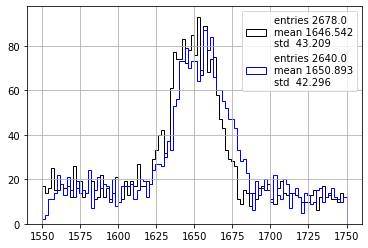

In [24]:
pltext.hist(dfevt.energy , 100, erange);
pltext.hist(dfevt.cenergy, 100, erange);

## Refine map

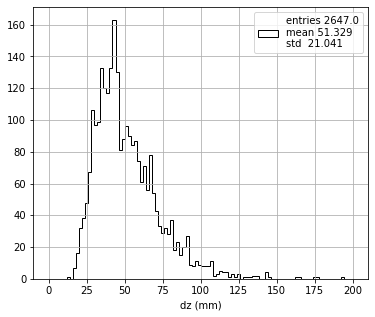

In [25]:
pltext.canvas(1, 1)
zmin = bhits.groupby('event')['z'].min()
zmax = bhits.groupby('event')['z'].max()
dz   = zmax - zmin
pltext.hist(dz, 100, (0, 200));
plt.xlabel('dz (mm)');

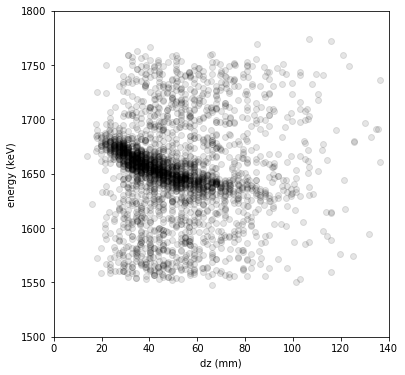

In [26]:
pltext.canvas(1, 1, 6, 6)
ene  = dfevt['cenergy']
zmin = dfevt['zmin']
zmax = dfevt['zmax']
dz   = zmax - zmin
plt.scatter(dz, ene, alpha = 0.1);
plt.xlim((0, 140)); plt.ylim((1500., 1800));
plt.xlabel('dz (mm)'); plt.ylabel('energy (keV)');

In [27]:
def get_dzprof(dat, enename = 'energy'):
    ene     = dat[enename]
    zmin    = dat['zmin']
    zmax    = dat['zmax']
    dz      = zmax - zmin
    sel     = np.ones(len(dz), bool)
    clean   = np.copy(sel)
    clean   = ut.in_range(dz, (0., 130))
    done    = False
    while (not done):
        dz0     = dz[clean]
        ene0    = ene[clean]
        dzprof, residuals = prof.profile((dz0,), ene0, bins = 50, counts_min = 20)
        done, usel = krana.accept_residuals(residuals, range = (-2.,2.), 
                                            fun = 'gaus+poly.1', min_sigma = 0.7)
        clean[clean == True] = usel
    return dz, ene, clean, dzprof

In [28]:
def plot_dzprof(dz, ene, sel, dzprof):
    ecor   = prof.profile_scale((dz,), ene, dzprof, 1600.)
    canvas = pltext.canvas(2, 2)
    canvas(1)
    pltext.hist(ecor[sel], 100, (1540., 1650));
    pltext.hfit(ecor[sel], 100, range = (1540., 1650.), fun = 'gaus+poly.1');
    canvas(2)
    plt.scatter(dz[sel], ecor[sel], alpha = 0.1);
    plt.xlim((0., 200));plt.ylim((1400., 1800.)); plt.xlim((0., 130));
    return

sigma 0.30 done  False  eff 70.39
sigma 0.53 done  False  eff 91.36
sigma 0.66 done  False  eff 97.52
sigma 0.69 done  False  eff 98.48
sigma 0.68 done  False  eff 98.77
sigma 0.70 done  False  eff 99.63
sigma 0.71 done  True  eff 100.00


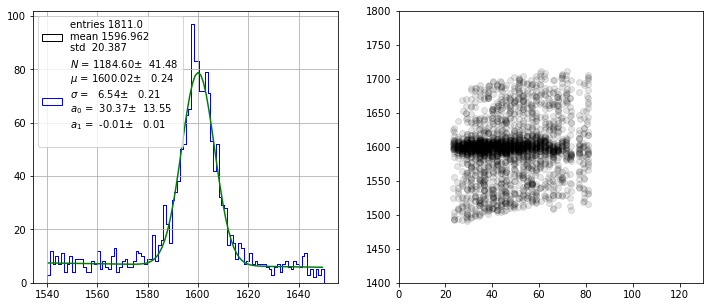

In [29]:
dz, ene, sel, dzprof = get_dzprof(dfevt, 'energy')
plot_dzprof(dz, ene, np.ones(len(dz), bool), dzprof)
cene = prof.profile_scale((dz,), ene, dzprof, 1600.)
dfevt['dzenergy'] = cene

sigma 0.31 done  False  eff 71.72
sigma 0.52 done  False  eff 91.10
sigma 0.65 done  False  eff 96.97
sigma 0.77 done  True  eff 100.00


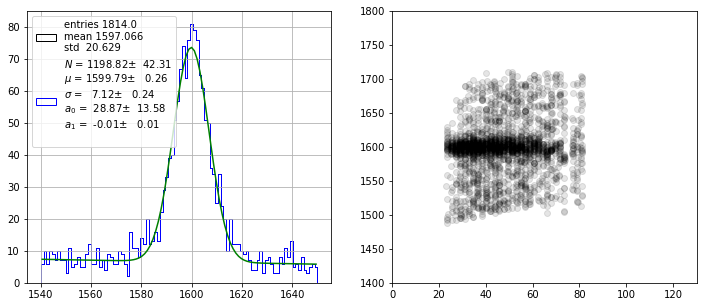

In [30]:
dz, enec, sel, dzprof = get_dzprof(dfevt, 'cenergy')
plot_dzprof(dz, enec, np.ones(len(dz), bool), dzprof)
cenec = prof.profile_scale((dz,), enec, dzprof, 1600.)
dfevt['dzcenergy'] = cenec

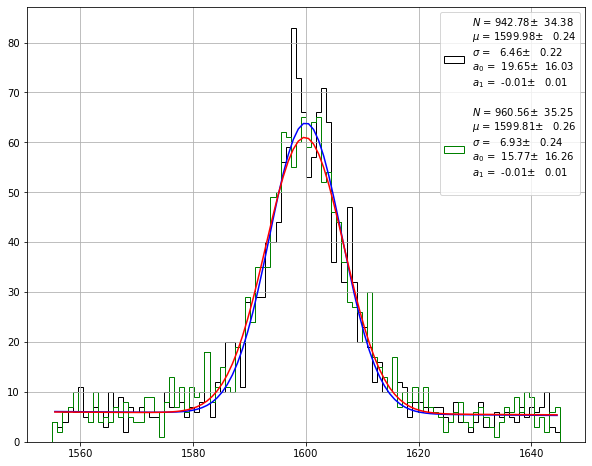

In [31]:
canvas = pltext.canvas(1, 1, 8, 10)
bins, range = 100, (1555, 1645)
pltext.hfit(cene , bins, range = range, fun = 'gaus+poly.1');
pltext.hfit(cenec, bins, range = range, fun = 'gaus+poly.1');

## Event study

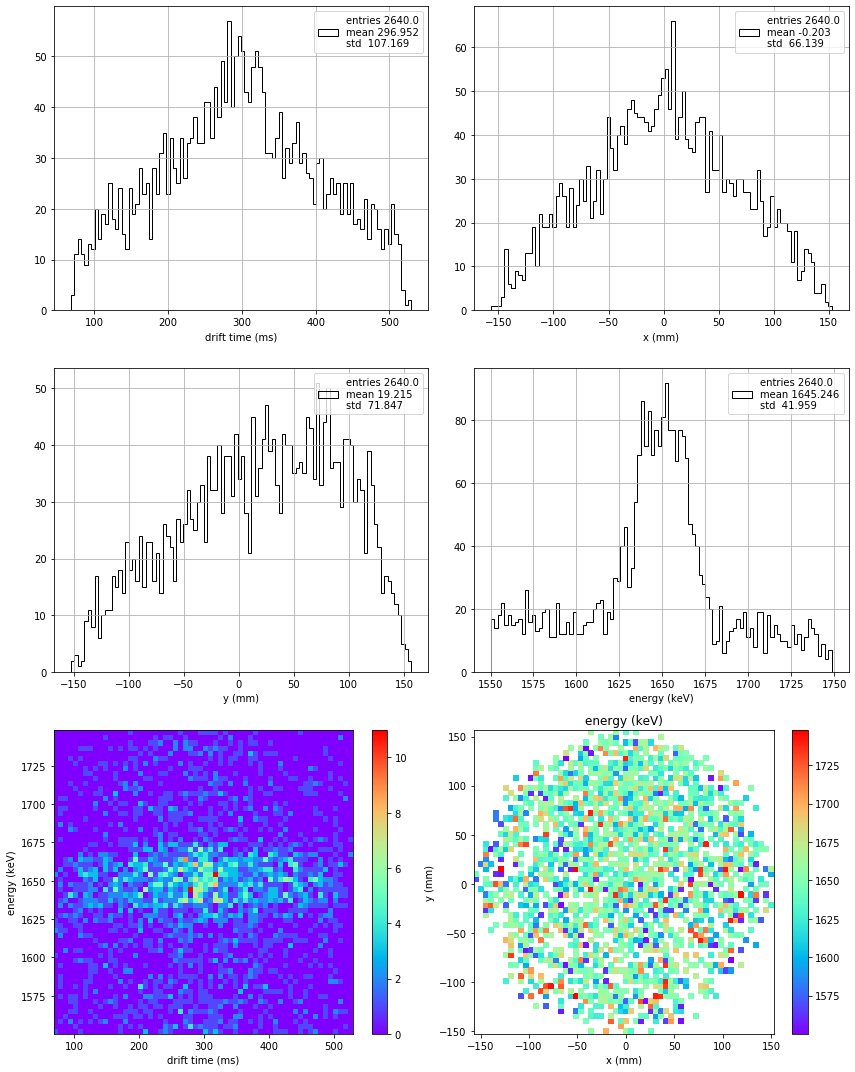

In [32]:
xsel = ut.in_range(dfevt.cenergy, erange)
krana.plot_data(dfevt[xsel], 60);

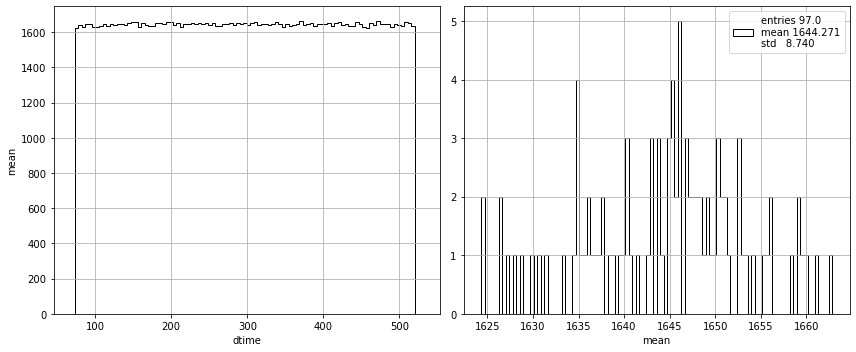

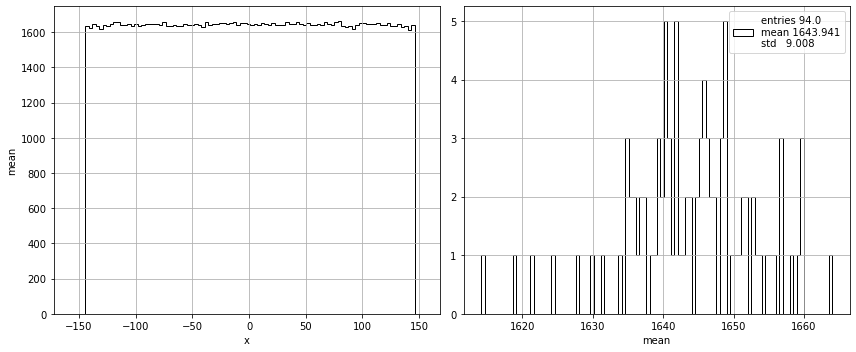

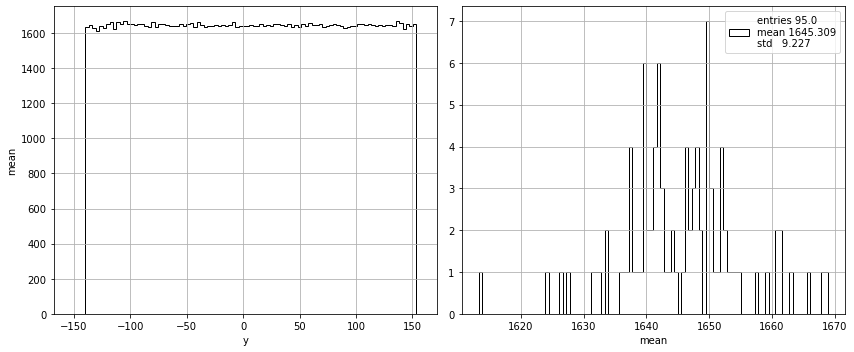

In [33]:
krana.plot_xydt_energy_profiles(dfevt[xsel], 100);

In [34]:
xsel = (ut.in_range(dfevt.dtime.values, (200, 400)))  
xsel = xsel & (ut.in_range(dfevt.x.values, (-80, 80)))
xsel = xsel & (ut.in_range(dfevt.y.values, (-80, 80)))

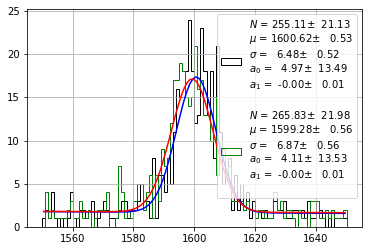

In [35]:
pltext.hfit(dfevt.dzenergy [xsel], 100, range = (1550, 1650), fun = 'gaus+poly.1');
pltext.hfit(dfevt.dzcenergy[xsel], 100, range = (1550, 1650), fun = 'gaus+poly.1');

In [36]:
6.87/1600 * 235.5

1.011178125

1.2957556749804038e-07


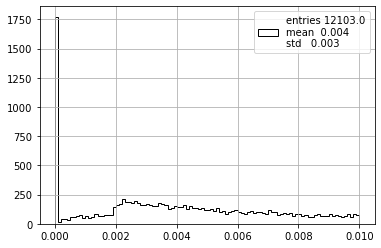

In [37]:
print(np.min(bhits.energy[bhits.energy > 0.]))
pltext.hist(1e3* bhits.energy, 100, (0, 0.01) );

In [42]:
xsel = (1e3 * bhits.energy) > 0.04
e0   = 1e3 * bhits[xsel].groupby('event')['energy'].sum()
e0c  = 1e3 * bhits[xsel].groupby('event')['cenergy'].sum()
e    = 1e3 * bhits      .groupby('event')['energy'].sum()
ee   = e * e0c/e0
dfevt['enorma'] = ee

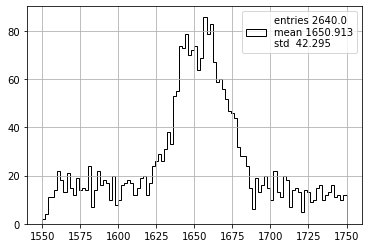

In [43]:
pltext.hist(dfevt.enorma, 100, erange);

sigma 0.31 done  False  eff 71.72
sigma 0.52 done  False  eff 91.15
sigma 0.65 done  False  eff 97.03
sigma 0.76 done  True  eff 100.00


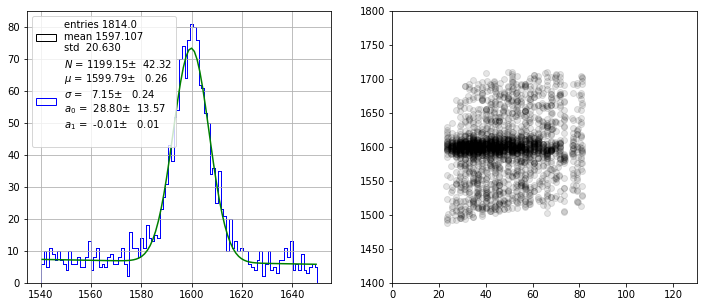

In [41]:
dz, enec, sel, dzprof = get_dzprof(dfevt, 'enorma')
plot_dzprof(dz, enec, np.ones(len(dz), bool), dzprof)
cenec = prof.profile_scale((dz,), enec, dzprof, 1600.)
dfevt['enorma'] = cenec